# Visualising our approach to tuning Ridge Regression

This notebook serves the purpose of presenting our key findings while tuning our ridge regression's parameters and showing how we set out to find these parameters, namely determining the lambda used for regularization and the degrees to which we augment our data. Further, we decide to illustrate why we decided to prioritise lower misclassification in determining these parameters than mean squared error, and reinforce what was taught to us, that the mean squared error can mislead if blindly trusted in classification problems.

In [1]:
import numpy as np
from helpers import build_poly, build_k_indices, fill_nan_closure, minmax_normalize_closure,\
standardize_closure, predict_without_classifying, batch_iter
from proj1_helpers import load_csv_data, predict_labels
from implementations import compute_mse, ridge_regression 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle # if reproduction of computation intensive graphs is desired

DATA_PATH = '../data/'
PLOT_OUTPUT_PATH = '../plots/'
seed = 12

# We work with the training data in this notebook
y, x, ids = load_csv_data(DATA_PATH+'train.csv')

# Fill all NA values (-999 in this case) with the median of each column - will compare later median vs mean but not now
fill_nan = fill_nan_closure(x, np.nanmedian)
x = fill_nan(x)

# Minmax normalization of x matrix - will compare minmax vs standardization later in this notebook but not now
minmax_normalize = minmax_normalize_closure(np.min(x, axis=0), np.max(x, axis=0))
x = minmax_normalize(x)

(250000, 30)


In [2]:
lambda_ = np.array([0]) # Removed regularization for illustrative purpose of why we preferred minimizing misclassification over mse
degrees = np.arange(1,7) 
k_fold = 5

def cross_validation(y, x, k_indices, k, lambda_, degree):
    
    # Current fold test indices are our k indices, all non-k indices are our train indices
    te_indice, tr_indice = k_indices[k], k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    # Split data according to determined indices
    y_te, y_tr = y[te_indice], y[tr_indice]
    x_te, x_tr = x[te_indice], x[tr_indice]
    
    # Build tildeX (including offset term) and augment to provided degree
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)
    
    # Compute optimal weights using normal form solution
    w, _ = ridge_regression(y_tr, tx_tr, lambda_)
    
    # Calculate fold MSE for training and test partitions
    mse_tr = compute_mse(y_tr, tx_tr, w)
    mse_te = compute_mse(y_te, tx_te, w)
    
    # Calculate fold misclassification % (ratio of how many inaccurate predictions were made)
    y_tr_pred = predict_labels(w, tx_tr)
    y_te_pred = predict_labels(w, tx_te) # we store the predictions on test to show what may drive mse losses in each degree 

    misclass_tr = sum(y_tr_pred != y_tr)/len(y_tr)
    misclass_te = sum(y_te_pred != y_te)/len(y_te)
    
    y_te_pred_pre_classification = predict_without_classifying(w, tx_te)
    
    return mse_tr, mse_te, misclass_tr, misclass_te, y_te_pred_pre_classification, w

def compare_mse_misclassification_tuning():
   
    # build fold indices to feed into cross validation
    k_indices = build_k_indices(y, k_fold, seed)

    # initiate empty lists to store average (over the folds) mse on training and test and average
    # misclassification on training on test 
    
    mse_te, mse_tr = [], []
    acc_te, acc_tr = [], []
    y_pred_te = []
    
    for deg in degrees:
        print(f'Computing for Degree {deg}')
        
        # store mses and misclassification for each fold
        mse_te_tmp, mse_tr_tmp = [], []
        acc_te_tmp, acc_tr_tmp = [], []
        y_pred_te_tmp = np.array([]) 
            
        for k in range(k_fold):

            fold_mse_tr, fold_mse_te, fold_acc_tr, fold_acc_te, y_te_fold_pred , _ = cross_validation(y, x, k_indices, k, lambda_, deg)

            # store mse, misclassification accuracy and predictions made of fold for logging
            mse_te_tmp.append(fold_mse_te) ; mse_tr_tmp.append(fold_mse_tr)
            acc_te_tmp.append(fold_acc_te) ; acc_tr_tmp.append(fold_acc_tr)
            y_pred_te_tmp = np.hstack((y_pred_te_tmp, y_te_fold_pred))

        # average the folds and store for logging    
        mse_te.append(np.mean(mse_te_tmp, axis=0)) ; mse_tr.append(np.mean(mse_tr_tmp, axis=0))
        acc_te.append(np.mean(acc_te_tmp, axis=0)) ; acc_tr.append(np.mean(acc_tr_tmp, axis=0))
        y_pred_te.append(y_pred_te_tmp)
        
    best_d_mse = degrees[np.argmin(mse_te)]
    best_d_misclass = degrees[np.argmin(acc_te)]

    # We recognize we selected the "best" values for each degree according to MSE (instead of misclassification %) but it still shows why MSE is flawed
    print(f'According to the lowest MSE the best degree was {best_d_mse}, while according to the lowest misclassifications it was {best_d_misclass}')
    
    return mse_te, mse_tr, acc_te, acc_tr, y_pred_te

mse_te, mse_tr, acc_te, acc_tr, y_pr = compare_mse_misclassification_tuning()

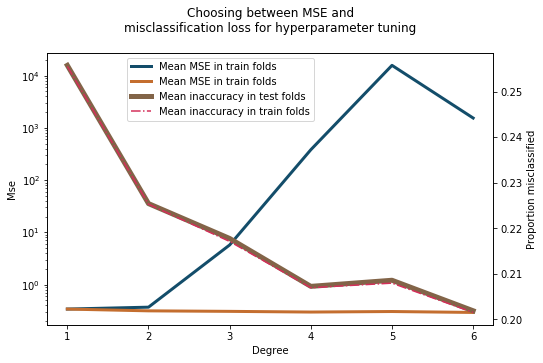

In [135]:
fig,ax = plt.subplots(figsize=(8,5))

lns1 = ax.plot(degrees, mse_te, color='#134d6a', linewidth=3, label='Mean MSE in train folds')
lns2 = ax.plot(degrees, mse_tr, color='#c46e2f', linewidth=3, label='Mean MSE in train folds')

ax2=ax.twinx()

lns3 = ax2.plot(degrees, acc_te, color='#826448', linewidth=5, label='Mean inaccuracy in test folds')
lns4 = ax2.plot(degrees, acc_tr, color='#d42e59', linestyle='dashdot', label='Mean inaccuracy in train folds')

ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('Mse')
ax.set_xticks(degrees)
ax2.set_ylabel('Proportion misclassified')

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=(0.18,0.75))

fig.savefig(PLOT_OUTPUT_PATH+"Comparing MSE and classification loss.pdf", bbox_inches='tight')

plt.title('Choosing between MSE and\nmisclassification loss for hyperparameter tuning\n')
plt.show()

Interesting, we observe that the MSE of the test folds of cross validation observe higher MSEs in higher degrees. We illustrate why this happens in the following graph. Specifically, we observe that the model predicts due to the polynomial augmented data some very distant prediction values of y (reminder that y obtains values -1 and 1), thus heavily influencing the MSE defined by $\frac{1}{2N}\sum_{n=1}^N (y-y_{pred})^2$. Thus conceptually the notion of distance does not make sense in our classification problem and we decide to choose our hyperparameters instead based on those hyperparameters which are accompanied by the lowest testing error. Note that we have included both the training and the test averages of both loss methods during the k-fold cross validation from which we observe overfitting should we blindly observe the MSE and forget our initial classification problem. This further influenced our decision to pick hyperparameters by the lowest class inaccuracy instead of MSE. It is however interesting that if we do introduce the regularization parameter, this does delay or even not show a point where the MSE skyrockets, due to overfitting prevention from the regularization - nonetheless the conceptual appeal presented the misclassification percentage as compelling.  

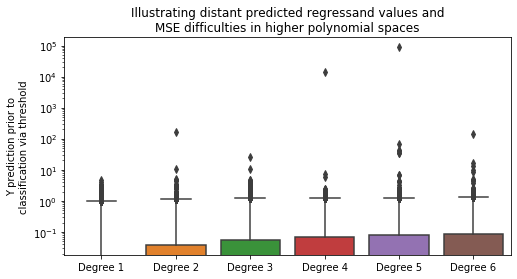

In [136]:
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=[lst.tolist() for lst in y_pr])
ax.set_xticklabels(['Degree '+str(d) for d in degrees])

ax.set_yscale('log')
ax.set_ylabel('Y prediction prior to\nclassification via threshold')

fig.savefig(PLOT_OUTPUT_PATH+"Distant regressand values.pdf", bbox_inches='tight')

plt.title('Illustrating distant predicted regressand values and\nMSE difficulties in higher polynomial spaces')
plt.show()

Now that we have determined we conceptually prefer misclassification error over MSE, we move on to tuning our parameters and select the best parameters from whichever is associated with the lowest misclassification error.

In [4]:
lambdas = np.logspace(-16,2,10)
degrees = np.arange(1,21) 
k_fold = 5
pickle_name = 'best degree.pkl'

def best_degree_and_lambda(pickle_name):
   
    # build fold indices to feed into cross validation
    k_indices = build_k_indices(y, k_fold, seed)

    # initiate empty lists to store best lambdas and their corresponding average (over the folds)
    # mse on training and test and average misclassification on training on test
    # Note that we say best now we determine via least missclassifications during testing in the folds
    
    best_lambdas = []
    best_mses_te, best_mses_tr = [], []
    best_acc_te, best_acc_tr = [], []
    
    for deg in degrees:
        print(f'Computing for Degree {deg}')
        
        # store mses and misclassification % for all lambdas in the given degree
        mse_te, mse_tr = [], []
        acc_te, acc_tr = [], []

        # main reason we decide to loop over some lambdas is to optimise towards the mse and give it its "best shot"
        for lambda_ in lambdas:

            mse_te_tmp, mse_tr_tmp = [], []
            acc_te_tmp, acc_tr_tmp = [], []
            
            for k in range(k_fold):

                fold_mse_tr, fold_mse_te, fold_acc_tr, fold_acc_te, _ , _ = cross_validation(y, x, k_indices, k, lambda_, deg)
                
                # store mse, misclassification accuracy and predictions made of fold for logging
                mse_te_tmp.append(fold_mse_te) ; mse_tr_tmp.append(fold_mse_tr)
                acc_te_tmp.append(fold_acc_te) ; acc_tr_tmp.append(fold_acc_tr)
                
            # average the folds and store for logging    
            mse_te.append(np.mean(mse_te_tmp, axis=0)) ; mse_tr.append(np.mean(mse_tr_tmp, axis=0))
            acc_te.append(np.mean(acc_te_tmp, axis=0)) ; acc_tr.append(np.mean(acc_tr_tmp, axis=0))
            
        # append only the mse and misclassification % for the lowest mse - this is our "best" lambda
        # we will use this to show why perhaps we want to move to minimizing the misclassification to select our best model
        ind_lambda_opt = np.argmin(acc_te)
        
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_mses_te.append(mse_te[ind_lambda_opt]) ; best_mses_tr.append(mse_tr[ind_lambda_opt])
        best_acc_te.append(acc_te[ind_lambda_opt]) ; best_acc_tr.append(acc_tr[ind_lambda_opt])
        
        # save progressively the values to later avoid re-computing
        with open(DATA_PATH + pickle_name, 'wb') as f:
            pickle.dump([best_lambdas, best_mses_te, best_mses_tr, best_acc_te, best_acc_tr], f)
        
    best_d = degrees[np.argmin(best_acc_te)]

    # We recognize we selected the "best" values for each degree according to MSE (instead of misclassification %) but it still shows why MSE is flawed
    print(f'According to the lowest number of missclassifications in the test folds of cross validation the best degree was: {best_d}')
    
    return best_d, best_lambdas, best_mses_te, best_mses_tr, best_acc_te, best_acc_tr

best_d, best_lambdas, best_mses_te, best_mses_tr, best_acc_te, best_acc_tr = best_degree_and_lambda(pickle_name)

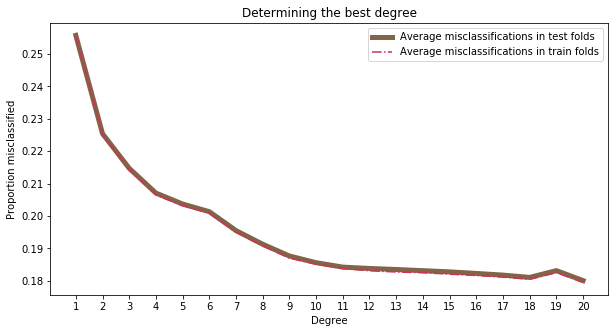

In [15]:
with open(DATA_PATH + 'best degree.pkl', 'rb') as f:
    best_lambdas, best_mses_te, best_mses_tr, best_acc_te, best_acc_tr = pickle.load(f)

fig,ax = plt.subplots(figsize=(10,5))

lns1 = ax.plot(degrees, best_acc_te, color='#826448', linewidth=5, label='Average misclassifications in test folds')
lns2 = ax.plot(degrees, best_acc_tr, color='#d42e59', linestyle='dashdot', label='Average misclassifications in train folds')

ax.set_xlabel('Degree')
ax.set_ylabel('Proportion misclassified')
ax.set_xticks(degrees)

ax.legend(loc='upper right')

fig.savefig(PLOT_OUTPUT_PATH+"Determining the best degree.pdf", bbox_inches='tight')

plt.title('Determining the best degree')
plt.show()

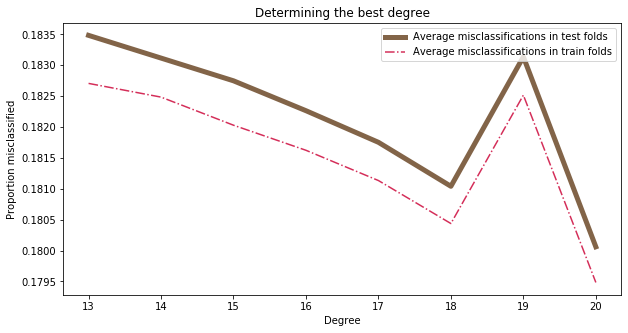

In [16]:
with open(DATA_PATH + 'best degree.pkl', 'rb') as f:
    best_lambdas, best_mses_te, best_mses_tr, best_acc_te, best_acc_tr = pickle.load(f)

zoom_degrees = np.arange(13,21)    
fig,ax = plt.subplots(figsize=(10,5))

lns1 = ax.plot(zoom_degrees, best_acc_te[np.min(zoom_degrees)-1:], color='#826448', linewidth=5, label='Average misclassifications in test folds')
lns2 = ax.plot(zoom_degrees, best_acc_tr[np.min(zoom_degrees)-1:], color='#d42e59', linestyle='dashdot', label='Average misclassifications in train folds')

ax.set_xlabel('Degree')
ax.set_ylabel('Proportion misclassified')
ax.set_xticks(zoom_degrees)

ax.legend(loc='upper right')

fig.savefig(PLOT_OUTPUT_PATH+"Zoom determining the best degree.pdf", bbox_inches='tight')

plt.title('Determining the best degree')
plt.show()

Particularly interesting here is the fact that now higher degrees are suggested to be preferred (though the marginal decrease in misclassification is less), some of which are extremely high, but perhaps even more surprising is the fact that the accuracy between train and test folds is so similar - perhaps even peculiarly similar. We now hone in on some of these higher degrees and try a wider variety of lambdas. Since they yield such similar results, we would like to investigate them and find another metric to differentiate them, particularly as degree 19 is the first degree increase which does not decrease the missclassifications. Now we also consider the variance of missclassification error throughout the different cross validation test folds for different lambdas and degrees.

In [11]:
def cross_validation_variance(degree, lambdas, k_fold):
    
    # same procedure as usual but now we want to retrieve unaggregated the losses from the folds to investigate variance!
    k_indices = build_k_indices(y, k_fold, seed)
    
    loss_te = []
    
    for lambda_ in lambdas:
        
        loss_te_tmp = []
        
        for k in range(k_fold):
            _, _, acc_tr, acc_te, _, _ = cross_validation(y, x, k_indices, k, lambda_, degree)
            loss_te_tmp.append(acc_te)
        
        loss_te.append(loss_te_tmp)
        
    return loss_te

def box_plot_variance(degree, lambdas, k_fold):
    test_losses = cross_validation_variance(degree, lambdas, k_fold)
    
    plt.boxplot(test_losses)
    plt.xticks(np.arange(1,len(lambdas)+1), labels=['%.1e' % x for x in lambdas.tolist()], rotation=90)
    plt.xlabel('Lambda')
    plt.ylabel('Misclassification share on test folds')
    plt.title(f'Degree {degree} - {k_fold} Fold')
    plt.show()

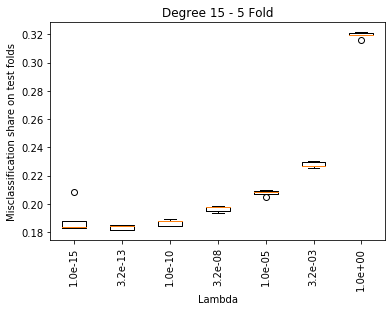

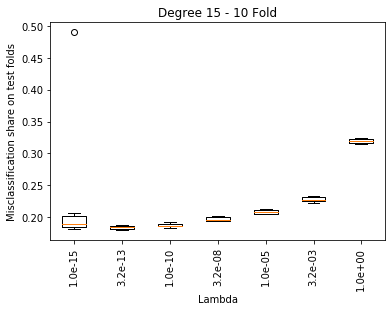

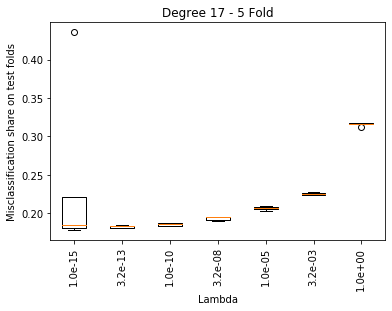

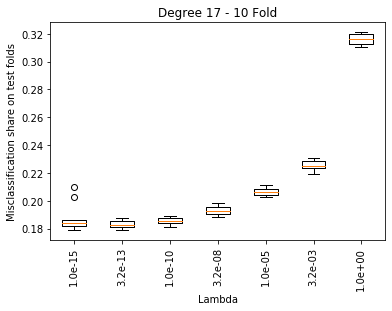

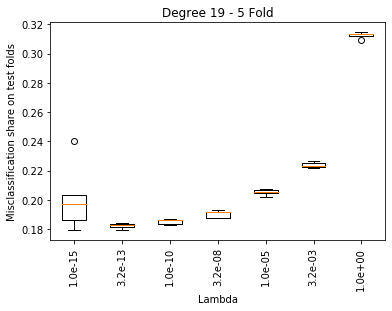

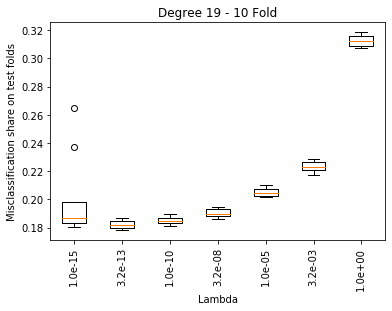

In [12]:
lambdas = np.logspace(-15,0,7)
degrees = [15,17,19]
for d in degrees: 
    box_plot_variance(d, lambdas, 5)
    box_plot_variance(d, lambdas, 10)

We observe that while on average the lowest lambda observes a low mean, it also is accompanied by a very large variance across testing folds. Instead surprisingly a lambda as low as 3.2e-13 seems to observe our best results over most of the higher degrees, and is accompanied by a low variance. Higher folds seem to help provide an estimation of accuracy of the model by taking into account this larger variance, and by training on a more ample size of the data, though at the cost of computation time.